In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms



In [3]:
class MilkAdulterationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = []
        self.transform = transform

        # Define the two classes: 0 for 'Not Adulterated', 1 for 'Adulterated'
        self.class_map = {
            "Not Adulterated": 0,
            "Adulterated": 1
        }

        for fat in os.listdir(root_dir):
            fat_path = os.path.join(root_dir, fat)
            if not os.path.isdir(fat_path):
                continue

            for percent in os.listdir(fat_path):
                percent_path = os.path.join(fat_path, percent)

                if percent == '0':
                    # No adulterant (Not Adulterated)
                    for img_name in os.listdir(percent_path):
                        self.data.append({
                            "img_path": os.path.join(percent_path, img_name),
                            "label": self.class_map["Not Adulterated"]
                        })
                else:
                    # With adulterant (Adulterated)
                    for img_name in os.listdir(percent_path):
                        self.data.append({
                            "img_path": os.path.join(percent_path, img_name),
                            "label": self.class_map["Adulterated"]
                        })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = Image.open(sample["img_path"]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, sample["label"]

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = MilkAdulterationDataset(root_dir="RGB", transform=transform)

# Load one sample
img, label = dataset[0]
print(label)  # Integer from 0 to 4


0


In [5]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Mapping from label index to class name
index_to_class = {
    0: "No Adulterant",
    1: "Adulteration",
}

# Show 5 samples from the dataset
for i in range(100):
    img, label = dataset[i]
    class_name = index_to_class[label]
    print(f"Image {i} → Label: {class_name}")


Image 0 → Label: No Adulterant
Image 1 → Label: No Adulterant


/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Image 2 → Label: No Adulterant
Image 3 → Label: No Adulterant
Image 4 → Label: No Adulterant
Image 5 → Label: No Adulterant
Image 6 → Label: No Adulterant
Image 7 → Label: No Adulterant
Image 8 → Label: No Adulterant
Image 9 → Label: No Adulterant
Image 10 → Label: No Adulterant
Image 11 → Label: No Adulterant
Image 12 → Label: No Adulterant
Image 13 → Label: No Adulterant
Image 14 → Label: No Adulterant
Image 15 → Label: No Adulterant
Image 16 → Label: No Adulterant
Image 17 → Label: No Adulterant
Image 18 → Label: No Adulterant
Image 19 → Label: No Adulterant


IsADirectoryError: [Errno 21] Is a directory: '/home/nitin/salmaan/RGB/Fat_1.5/15/Detergent'

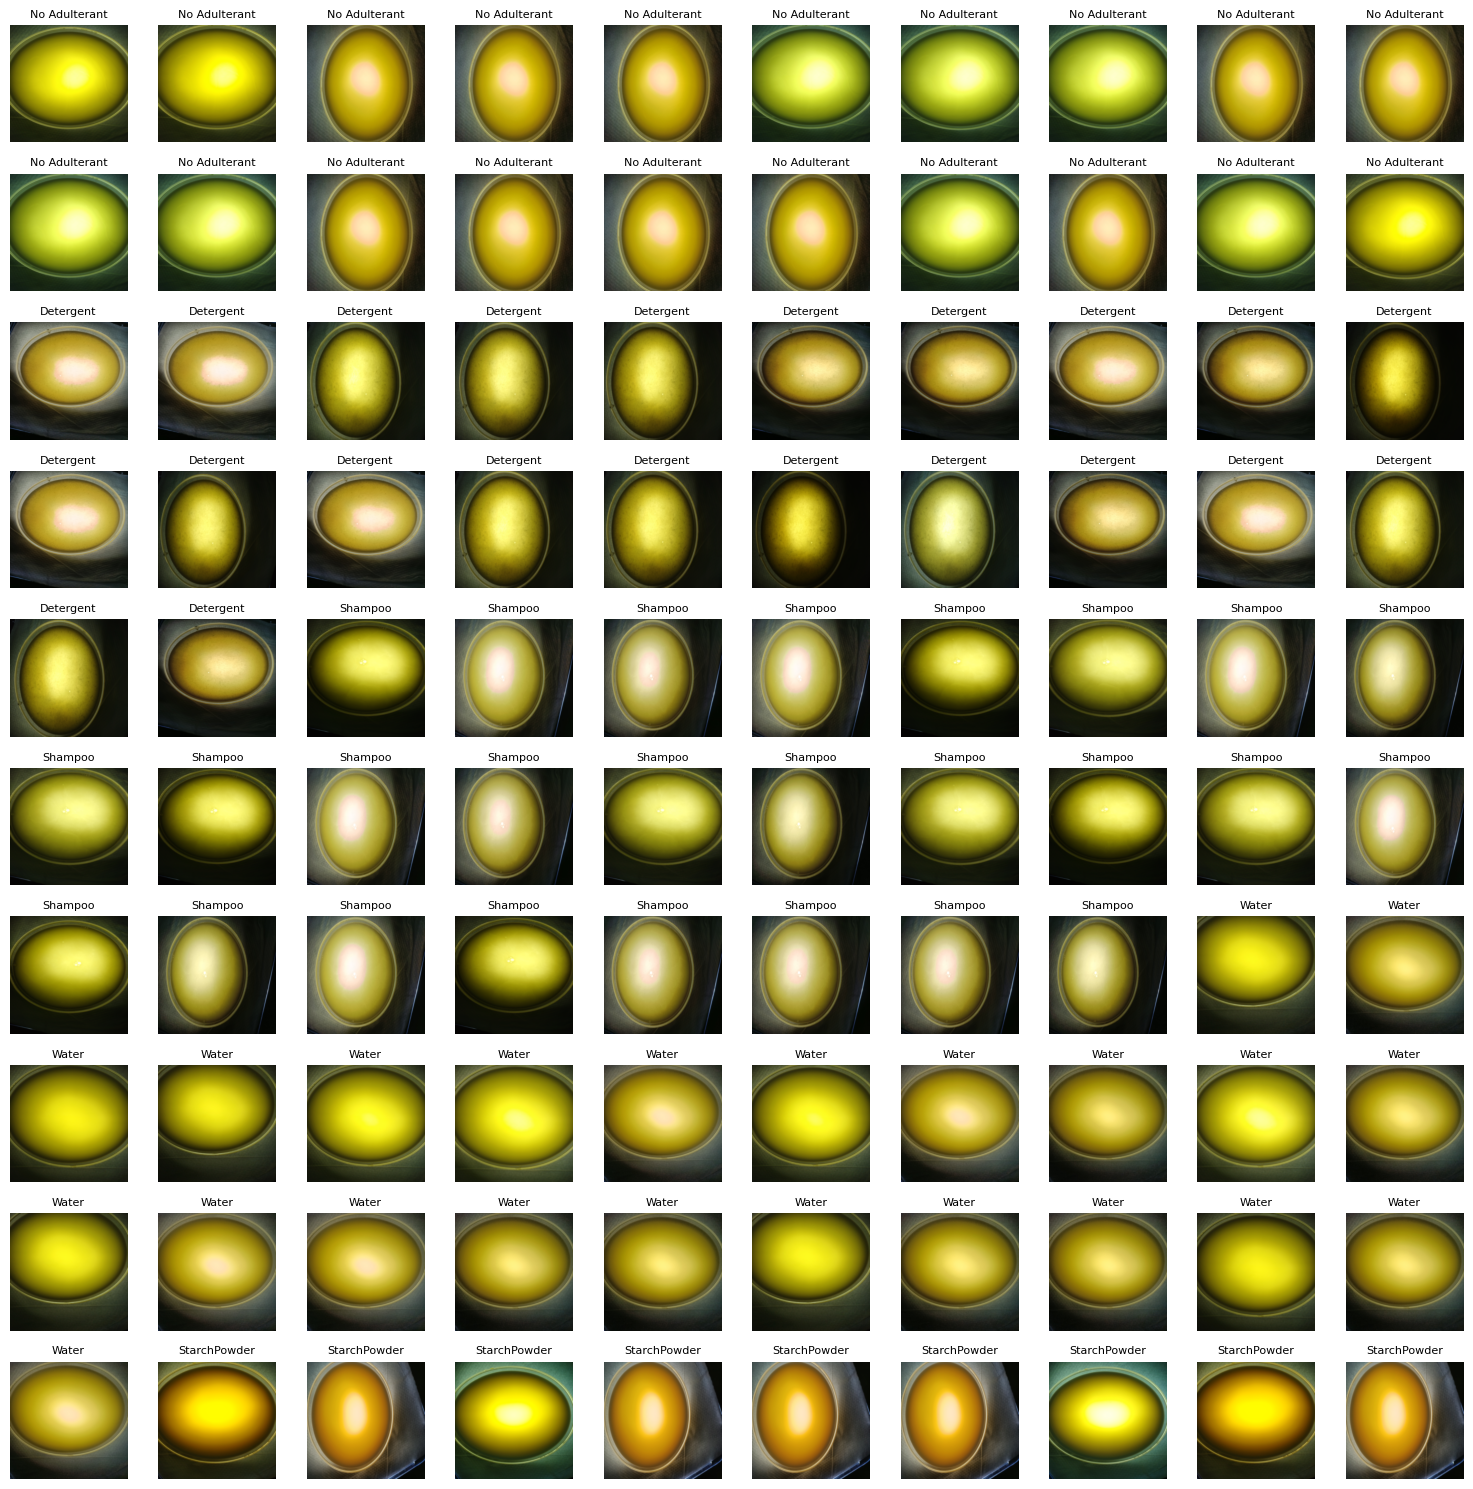

In [11]:
fig, axs = plt.subplots(10, 10, figsize=(15, 15))

for i in range(100):  # Loop through 100 images
    img, label = dataset[i]  # Get image and label
    img = img.permute(1, 2, 0)  # Convert from CHW to HWC format
    row, col = divmod(i, 10)  # Get row and column index

    axs[row, col].imshow(img)
    axs[row, col].set_title(index_to_class[label], fontsize=8)
    axs[row, col].axis('off')  # Hide axes for cleaner look

plt.tight_layout()
plt.show()


In [13]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Define dataset transformations (augmentation + normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  
])

# Load dataset
dataset = MilkAdulterationDataset(root_dir="RGB", transform=transform)

# Split into training and validation
train_size = int(0.8 * len(dataset))  # 80% training, 20% validation
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training Samples: {len(train_dataset)}, Validation Samples: {len(val_dataset)}")


Training Samples: 862, Validation Samples: 216


In [14]:
import torch
import timm
import torch.nn as nn

# Define DeiT model (without pre-trained weights)
model = timm.create_model("deit_tiny_patch16_224", pretrained=False, num_classes=5)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)  # Check model architecture


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


In [15]:
import torch.optim as optim

# Loss function (CrossEntropy for classification)
criterion = nn.CrossEntropyLoss()

# Optimizer (AdamW works well for transformers)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.05)

# Learning rate scheduler (reduces LR over time)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [16]:
num_epochs = 10  # Adjust as needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    scheduler.step()  # Adjust learning rate
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/10], Loss: 1.6169
Epoch [2/10], Loss: 1.5431
Epoch [3/10], Loss: 1.4059
Epoch [4/10], Loss: 1.5619
Epoch [5/10], Loss: 1.4473
Epoch [6/10], Loss: 1.1748
Epoch [7/10], Loss: 1.0995
Epoch [8/10], Loss: 1.0371
Epoch [9/10], Loss: 0.9837
Epoch [10/10], Loss: 0.9525


In [17]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")


Validation Accuracy: 64.35%


In [18]:
# Save the trained model
torch.save(model.state_dict(), "deit_milk_adulteration.pth")
print("Model saved as deit_milk_adulteration.pth")


Model saved as deit_milk_adulteration.pth
